# Una distribuzione con code Gaussiane asimmetriche




 * Si scriva una libreria di Python che contenga l'implementazione di una distribuzione di densità di probabilità, chiamata `double_Gaus`, definita sull'asse reale. La funzione dovrà possedere un massimo e due code Gaussiane, a destra e sinistra del massimo rispettivamente, con sigma differenti ($\sigma_\textrm{sx}$ e $\sigma_\textrm{dx}$), ricordando che la funzione deve essere continua su tutto l'asse reale; se ne faccia un disegno per controllare il risultato.

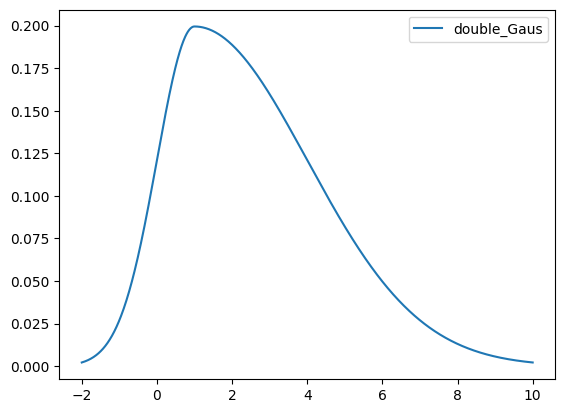

In [1]:
from lib import double_Gaus
import matplotlib.pyplot as plt
import numpy as np

mean = 1
sigma_sx = 1
sigma_dx = 3

x_axis = np.linspace (mean - 3 * sigma_sx, mean + 3 * sigma_dx, 1000)
y_axis = []
v_double_Gaus = np.vectorize (double_Gaus)
y_axis = v_double_Gaus (x_axis, mean, sigma_sx, sigma_dx)

fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.plot (x_axis, y_axis, label = 'double_Gaus')
ax.legend ()
plt.show ()


 * si controlli che la funzione è normalizzata, utilizzando il metodo *hit-or-miss* di integrazione

In [2]:
from lib import integral_HOM

func = lambda x : double_Gaus (x, mean, sigma_sx, sigma_dx)
integral = integral_HOM (func, mean - 3 * sigma_sx, mean + 3 * sigma_dx, func (mean), 10000)

print ('the resulting integral is:', integral[0] , '+-', np.sqrt (integral[1]))

the resulting integral is: 0.9924088167266041 +- 0.011792403313556125



 * si generi un campione di 1000 punti pseudo-casuali distribuiti secondo la la pdf `double_Gaus` utilizzando il metodo *try-and-catch*, se ne disegni l'istogramma scegliendo con un algoritmo appropriato minimo, massimo e numero di bin e si stampino a schermo media e mediana del campione ottenuto.

mean =  2.5685364451308526
median =  2.26315498448556
sigma =  2.0668814886102957
skewness =  0.6299095592794156
kurtosis =  0.06292229212119471


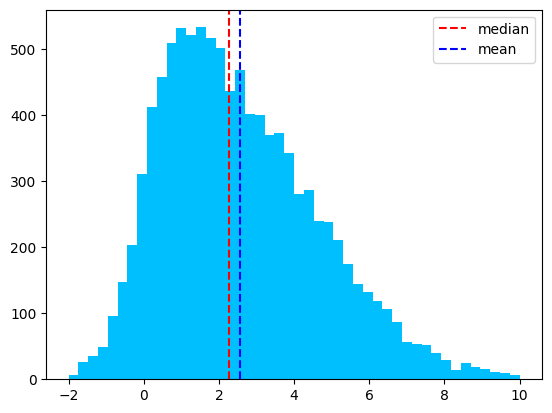

In [3]:
from lib import generate_TAC, sturges
from stats import stats

sample = generate_TAC (func, mean - 3 * sigma_sx, mean + 3 * sigma_dx, func (mean), 10000)

h_min = np.floor (min (sample))
h_max = np.ceil (max (sample))
n_bins = sturges (len (sample))

bin_content, bin_edges = np.histogram (sample, bins = n_bins, range = (h_min, h_max))

fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.hist (sample,
         bins = bin_edges,
         color = 'deepskyblue',
        )

my_stats = stats (sample)

print ('mean = ', my_stats.mean ())
print ('median = ', my_stats.median ())
print ('sigma = ', my_stats.sigma (True))
print ('skewness = ', my_stats.skewness ())
print ('kurtosis = ', my_stats.kurtosis ())

ax.axvline (x=my_stats.median (), color='red', linestyle='--', label='median')
ax.axvline (x=my_stats.mean (), color='blue', linestyle='--', label='mean')
ax.legend ()


 * Si assuma che ($\sigma_\textrm{sx} < \sigma_\textrm{dx}$) e si determini una formula che ricavi il rapporto $\sigma_\textrm{dx} / \sigma_\textrm{sx}$ a partire dalla differenza fra media e dalla mediana del campione, utilizzando il metodo dei *toy experiment* per determinarla empiricamente.

In [4]:
sigma_sx = 1

means = []
mean_errors = []
medians = []
ratios = []
for sigma_dx in np.arange (1., 100., 1):
    sample = generate_TAC (func, mean - 4 * sigma_sx, mean + 4 * sigma_dx, func (mean), 50000)
    my_stats = stats (sample)
    means.append (my_stats.mean ())
    mean_errors.append (my_stats.sigma_mean (True))
    medians.append (my_stats.median ())
    ratios.append (sigma_dx/sigma_sx)

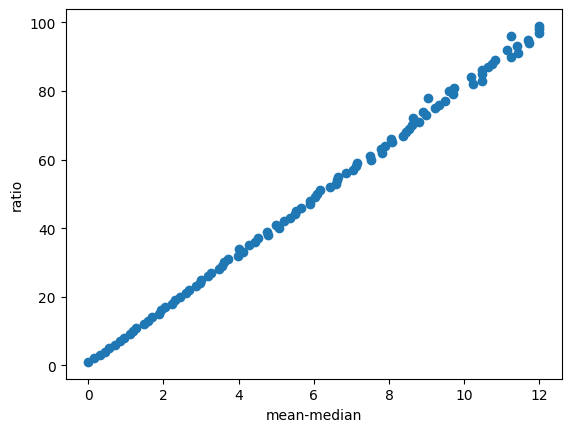

In [5]:
# prima ispezione del risultato dei toy experiment

fig, ax = plt.subplots (nrows = 1, ncols = 1)
difference = [a - b for a, b in zip(means, medians)]
ax.scatter (difference, ratios, marker = 'o')
ax.set_xlabel ('mean-median')
ax.set_ylabel ('ratio')
plt.show ()

In [6]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import chi2

# funzione di fit
def func (x, m, q): return m * x + q

# ordinamento dei punti, per essere sicuri che iMinuit faccia il fit su tutto l'intervallo
sigma_y = np.ones (len (ratios))
zipped = zip (difference, ratios, mean_errors)
# Sort the zip object by the first element (i.e., by list1)
sorted_zipped = sorted (zipped, key=lambda x: x[0])
# Unzip the sorted result back into separate lists (if needed)
difference_sort, ratios_sort, mean_errors_sort = zip (*sorted_zipped)

difference_errors = [2*x for x in mean_errors_sort] # media e mediana sono calcolate sugli stessi eventi, quindi assunte correlate
least_squares = LeastSquares (ratios_sort, difference_sort, difference_errors, func)
my_minuit = Minuit (least_squares, m = 1, q = 0)
my_minuit.migrad ()

is_valid = my_minuit.valid
print ('successo del fit: ', is_valid)

print ('p-value associato al fit:', 1. - chi2.cdf (my_minuit.fval, df = my_minuit.ndof))

print ("La relazione empirica fra il rapporto delle sigma e la differenza fra media e mediana e' lineare:")
print ("rapporto = ", 1. / my_minuit.values[0], "* (media - mediana)")

display (my_minuit)

successo del fit:  True
p-value associato al fit: 0.9999979997848075
La relazione empirica fra il rapporto delle sigma e la differenza fra media e mediana e' lineare:
rapporto =  7.966523053164452 * (media - mediana)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 45.67 (χ²/ndof = 0.5)      │              Nfcn = 35               │
│ EDM = 2.03e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │ 125.5e-3  │  0.6e-3   │            │            │         │         │       │
│ 1 │ q    │  -0.097   │   0.007   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        m        q │
├───┼───────────────────┤
│ m │ 3.84e-07  -1.8e-6 │
│ q │  -1.8e-6 4.32e-05 │
└───┴───────────────────┘